In [236]:
import pandas as pd
import quantstats as qs

from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

### Data

In [237]:
live = True
market_cap_threshold = 2_000_000_000

In [238]:
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
market_cap = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])

In [239]:
price = price.merge(market_cap, left_index=True, right_index=True, how='left')

In [240]:
price = create_return(price, [1])
price['RET_01'] = price.groupby('permno')['RET_01'].shift(-1)

### Trend Signal

In [241]:
mov_avg_list = [5, 15, 21, 60, 252]
for mov_avg in mov_avg_list:
    price[f'ma_{mov_avg}'] = price.groupby('permno')['Close'].rolling(mov_avg).mean().reset_index(level=0, drop=True)

### Backtest

In [242]:
price['vol'] = price.groupby('permno')['RET_01'].rolling(60).std().reset_index(level=0, drop=True)
price['inv_vol'] = 1 / price['vol']

In [267]:
# MA Crossover
price['signal'] = ((price['market_cap'] > market_cap_threshold) & (price['ma_60'] > price['ma_252'])).astype(int)

In [270]:
# MA Above
# Condition where all MAs are greater than Close
condition_all_above = ((price['ma_5'] > price['Close']) & 
                       (price['ma_60'] > price['Close']) & 
                       (price['ma_252'] > price['Close']))

# Condition where all MAs are less than Close
condition_all_below = ((price['ma_5'] < price['Close']) & 
                       (price['ma_60'] < price['Close']) & 
                       (price['ma_252'] < price['Close']))

# Generating signal: 1 if all above, -1 if all below, else 0
price['signal'] = 0  # Default value
price.loc[condition_all_above & (price['market_cap'] > market_cap_threshold), 'signal'] = 1
price.loc[condition_all_below & (price['market_cap'] > market_cap_threshold), 'signal'] = 0

In [271]:
# Adjust returns based on signal
price['sig_ret'] = price['RET_01'] * price['signal']
ret_daily = price.groupby(level='date').apply(lambda x: pd.Series({
    'sum_sig_ret': x['sig_ret'].sum(),
    'count': (x['signal'].abs() > 0).sum()
}))
ret_daily['ewp_ret'] = ret_daily['sum_sig_ret'] / ret_daily['count']
ewp_ret = ret_daily['ewp_ret']

In [272]:
inv_vol_port = price[(price['signal'].abs() == 1)]
inv_vol_port['norm_inv_vol'] = inv_vol_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
inv_vol_port['weighted_ret'] = inv_vol_port['RET_01'] * inv_vol_port['norm_inv_vol'] * inv_vol_port['signal']
inv_vol_ret = inv_vol_port.groupby('date')['weighted_ret'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ------------
Start Period               2006-01-03   2006-01-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          253.88%      3,953.21%
CAGR﹪                     5.01%        15.38%

Sharpe                     0.46         0.92
Prob. Sharpe Ratio         97.29%       100.0%
Smart Sharpe               0.44         0.88
Sortino                    0.64         1.37
Smart Sortino              0.61         1.31
Sortino/√2                 0.45         0.97
Smart Sortino/√2           0.43         0.93
Omega                      1.19         1.19

Max Drawdown               -56.47%      -50.75%
Longest DD Days            1982         866
Volatility (ann.)          19.79%       26.2%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-16,2020-03-20,2020-11-05,295,-50.747224,-47.254437
2,2008-05-19,2008-11-19,2008-12-30,226,-40.304396,-36.049488
3,2021-06-28,2022-10-13,2023-11-10,866,-37.592889,-36.180928
4,2011-04-29,2011-09-30,2012-01-18,265,-29.722477,-26.613268
5,2015-05-04,2016-02-10,2016-04-25,358,-28.299208,-26.613950


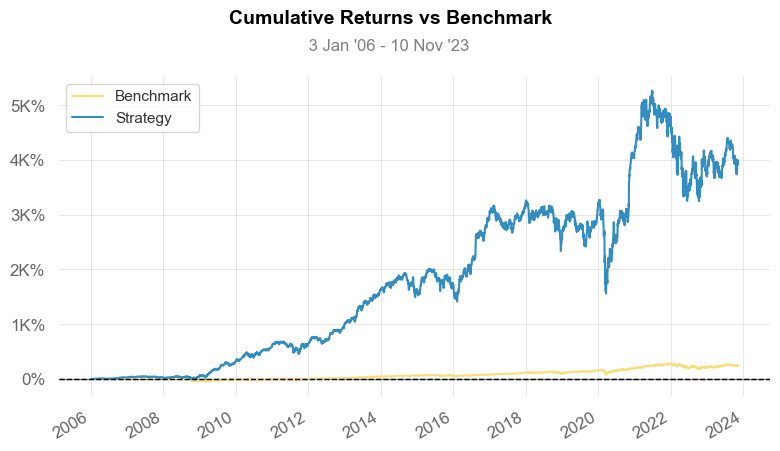

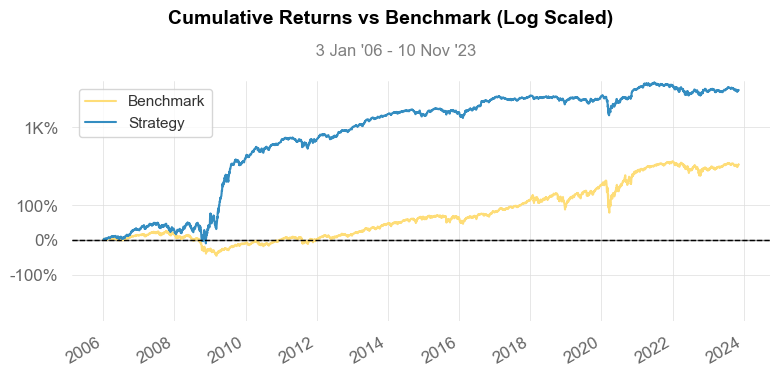

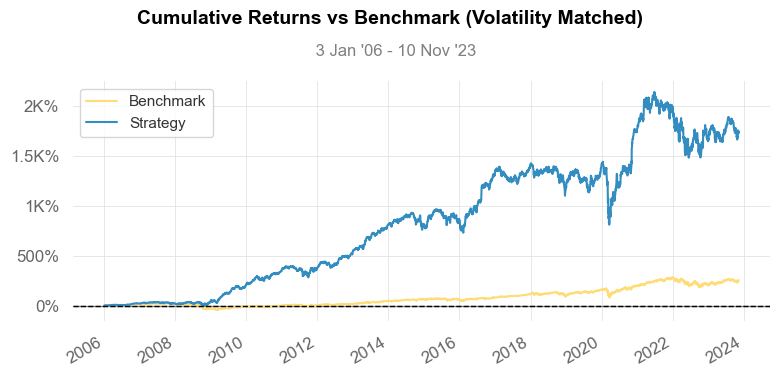

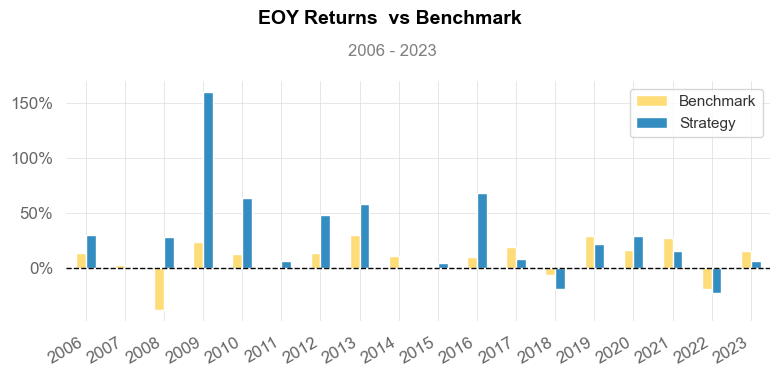

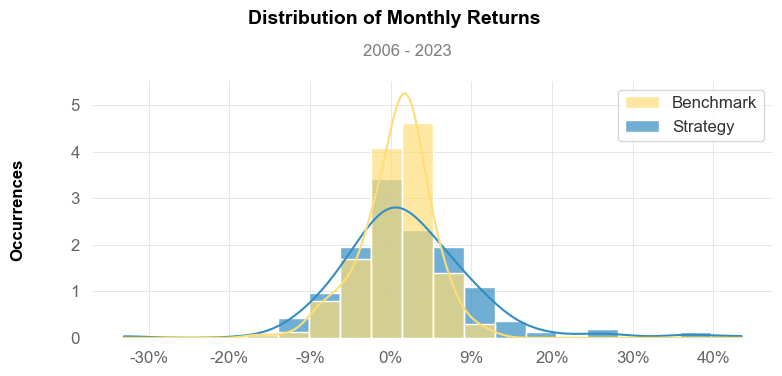

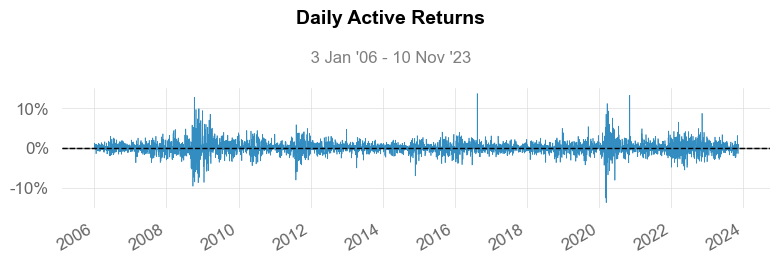

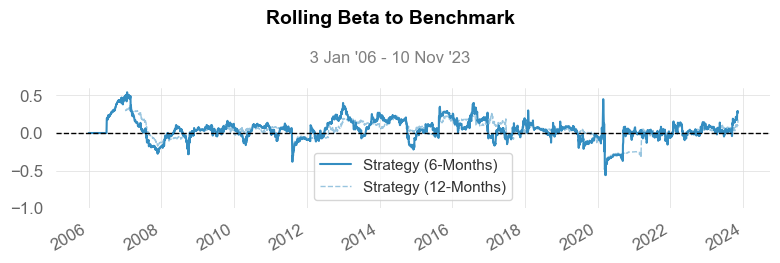

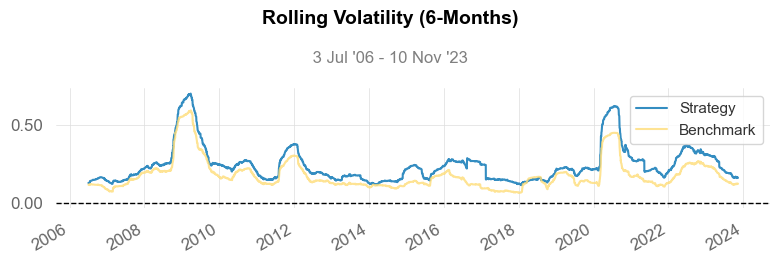

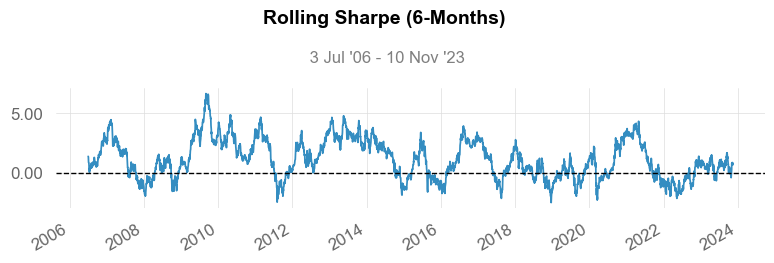

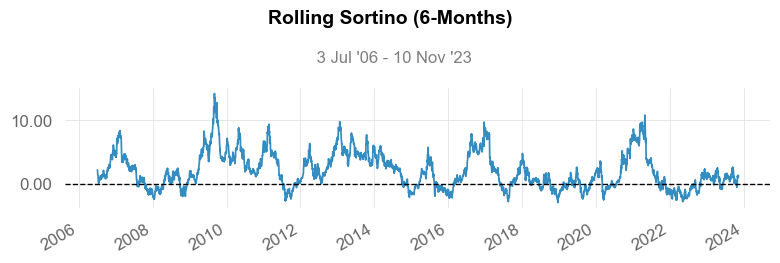

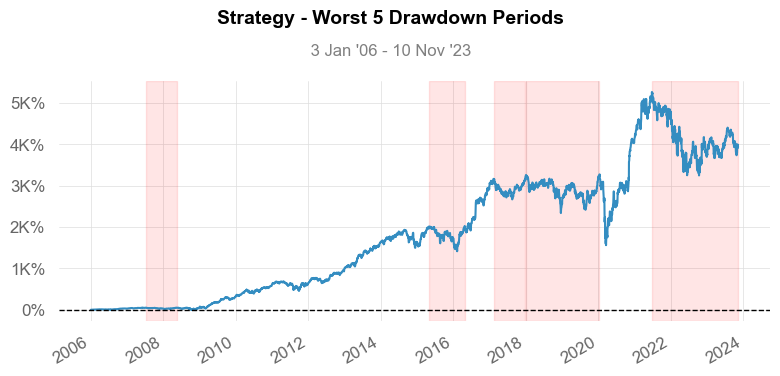

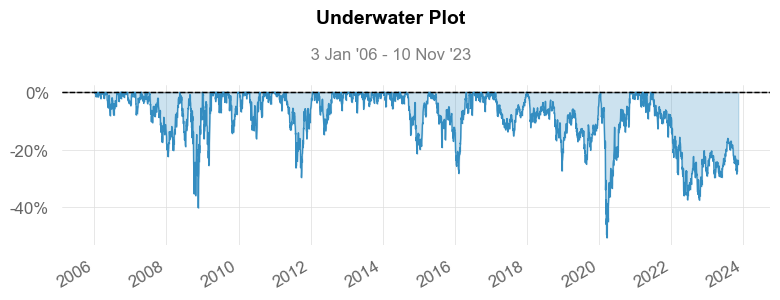

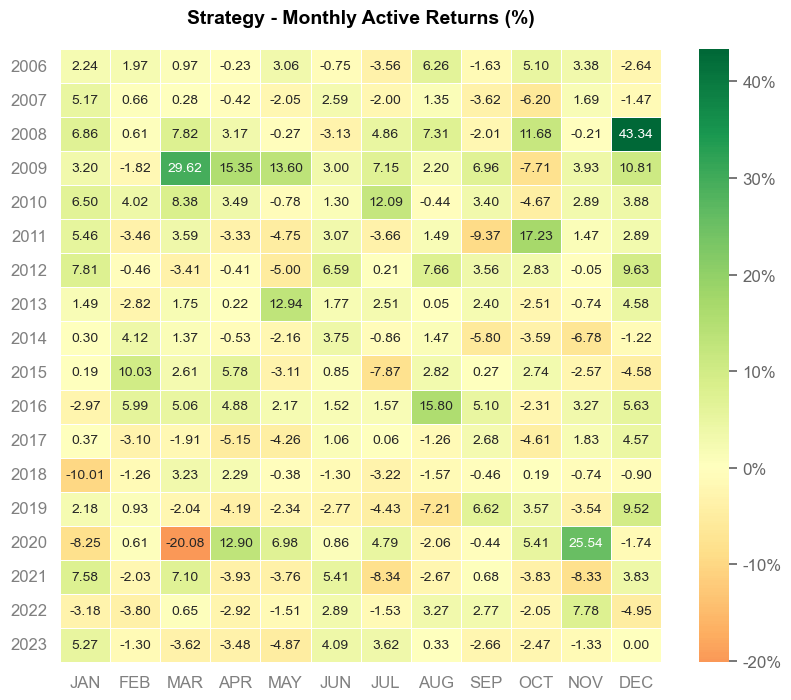

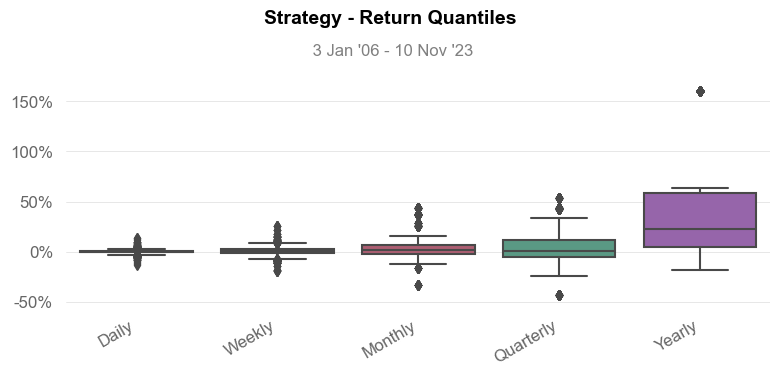

In [273]:
qs.reports.full(ewp_ret, 'SPY')